![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Seasonal forecast download and plot for one coordinate

### About

This notebook is based on "Seasonal Forecast Anomalies": https://ecmwf-projects.github.io/copernicus-training-c3s/sf-anomalies.html
It was mainly modified to use daily resolution instead of monthly.
It provides a practical introduction to calculating seasonal forecast with data from the Copernicus Climate Change Service (C3S). C3S seasonal forecast products are based on data from several state-of-the-art seasonal prediction systems. In this tutorial we shall focus on the [ECMWF SEAS5 model](https://confluence.ecmwf.int/display/CKB/Description+of+SEAS5+C3S+contribution), which is one of the forecasting systems available through C3S.

The tutorial will demonstrate how to access real-time forecast data of total precipitation, with a forecast start date in May 2023 and 6-7 monthly lead times (up to October 2023). Hindcast data for the same start date and lead-time months in the reference period 1993 to 2016 will also be downloaded. 

The tutorial will then show how to interpolate in a coordinate for both the forecast and hindcast data. (The climate mean for the reference period will be computed and this reference mean will be subtracted from the real-time forecast data to derive monthly anomalies BORRAR?). These will be visualised as time series. Finally, 3-monthly anomalies will be calculated and visualised in an interactive plot, as a demonstration of how to reproduce similar [charts available through C3S](https://climate.copernicus.eu/charts/c3s_seasonal/).


The notebook has the following outline:
* 1 - Process seasonal hindcast grib files (24h, total precipitation)
* 2 - Export seasonal hindcast csv files (daily precipitation)
* 3 - Real-time forecasts

<br>

### Install packages

In [ ]:
# Install CDS API for downloading data from the CDS
#!pip install cdsapi

In [ ]:
# Install cfgrib to enable us to read GRIB format files
#!conda install -c conda-forge cfgrib -y

In [1]:
# Miscellaneous operating system interfaces
import os

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import scipy

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

# 1 - Process seasonal hindcast grib files (24h, total precipitation)

<hr>

In [2]:
# Define the coordinates to interpolate to
interp_longitude=2.25 #reach1=reach2=2.25
interp_latitude=42.3  #reach1=42.3, reach2=42.05
variable_name = 'total_precipitation'
var_short = 'tp'
forecast_year = 2024

Here we specify a data directory in which the grib files are located

In [3]:
DATADIR = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal'

Obtaining daily precipitation data sets

In [26]:
#list to store results
hind_all = []

#for loop for all years (1993-2016)
for time in range(1993,2017):
    
    #for loop for all months (1-12)
    for month_num in range(1,13):
        
        #open file for the corresponding month
        hind = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_1993-2016_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')
        hind_var = hind[var_short]

        # Interpolate the values for the specified coordinates
        hind_interp = hind_var.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")
    
        #create the subset for the specific year and month
        year_subset = f'{time}-{month_num:02d}-01T00:00:00.000000000'
        subset_hind = hind_interp.sel(time=year_subset)
    
        #verify number of members
        num_members = len(subset_hind)
        
        #calculate the difference throughout the steps (215 days) to obtain daily accumulated precipitation
        subset_hind_diff = subset_hind.diff(dim='step') # by default does it along the last axis 
    
        #add results to the list
        hind_all.append(subset_hind_diff)

Save data to npy file (one per subcatchment C1, C2)

In [28]:
from copy import deepcopy
hind_all_tp = np.empty(1,dtype=object)
hind_all_tp[0] = deepcopy(hind_all)
np.save('hind_all_tp_C1',hind_all_tp) #change _C1 or C2 accordingly.

# 2. Export seasonal hindcast csv files (daily precipitation)

Import npy file to create hind files for each year, month and member

In [71]:
hind_all = (np.load('hind_all_tp_C1.npy',allow_pickle=True))[0]   ##change _C1 or C2 accordingly
hind_all

[<xarray.DataArray 'tp' (number: 25, step: 214)>
 array([[0.        , 0.00052643, 0.        , ..., 0.        , 0.        ,
         0.00012207],
        [0.        , 0.00041199, 0.        , ..., 0.0012207 , 0.00012207,
         0.00012207],
        [0.        , 0.00135803, 0.00048828, ..., 0.00146484, 0.        ,
         0.        ],
        ...,
        [0.        , 0.00196075, 0.0001297 , ..., 0.        , 0.00024414,
         0.        ],
        [0.        , 0.00065613, 0.        , ..., 0.        , 0.01818848,
         0.0012207 ],
        [0.        , 0.00016785, 0.        , ..., 0.00048828, 0.        ,
         0.00012207]], dtype=float32)
 Coordinates:
   * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
     time        datetime64[ns] 1993-01-01
   * step        (step) timedelta64[ns] 2 days 3 days ... 214 days 215 days
     surface     float64 0.0
     valid_time  (step) datetime64[ns] 1993-01-03 1993-01-04 ... 1993-08-04
     latitude    float64 42

In [32]:
#exploring npy file
print(type(hind_all))
print(len(hind_all))

<class 'list'>
288


In [33]:
# Set path to save hindcast files
save_path = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast'

In [72]:
# Define a function to save each sub-array
def save_sub_array(dataarray, number, list_idx, save_path):
    
    # Extract the sub-array
    sub_array = dataarray.sel(number=number).values
        
    # Convert the precipitation from m to mm
    sub_array_mm = sub_array*1000
        
    # Define the filename (25 members, 288 times(24 years X 12 months))
    filename = os.path.join(save_path,f"hind_C1_tp_member{number}_time{list_idx}.csv") #change _C1 or C2 accordingly
    
    # Save the sub-array to a .csv file
    np.savetxt(filename, sub_array_mm, delimiter=',', fmt='%.6f')
    print(f"Saved {filename}")
    
# Iterate through the list
for list_idx, dataarray in enumerate(hind_all):
    # Ensure the 'number' coordinate is numeric
    if isinstance(dataarray['number'].values, np.ndarray):
        numbers = dataarray['number'].values
    else:
        numbers = np.arange(len(dataarray['number']))
    
    # Iterate through each 'number'
    for number in numbers:
        save_sub_array(dataarray, number, list_idx, save_path)


Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time0.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time0.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time0.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time0.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time0.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time0.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time0.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time2.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time2.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time2.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time2.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time2.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time2.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time3.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time5.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time6.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time6.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time6.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time6.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time6.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time6.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time8.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time8.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time8.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time8.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time8.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time8.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time9.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time12.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time12.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time12.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time12.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time12.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time12.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time12.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcas

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time15.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time15.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time15.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time15.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time15.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time15.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time15.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time20.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time20.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time20.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time20.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time21.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time21.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time21.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hin

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time24.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time24.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time24.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time24.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time24.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time24.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time24.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time28.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time28.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time28.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time28.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time28.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time28.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time28.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time33.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time33.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time33.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time33.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time33.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time33.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time33.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time36.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time36.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time36.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time36.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time36.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time36.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time36.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time39.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time39.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time39.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time39.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time39.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time39.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time39.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time44.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time44.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time44.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time44.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time44.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time44.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time44.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time48.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time48.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time48.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time48.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time48.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time48.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time48.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/h

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time52.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time52.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time52.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time52.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time52.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time52.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time52.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcas

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time55.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time55.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time55.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time55.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time55.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time55.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time55.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time60.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time60.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time60.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time60.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time60.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time60.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time60.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time63.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time63.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time63.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time63.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time63.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time63.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time63.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time67.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time67.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time67.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time67.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time67.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time67.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time67.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindca

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time70.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time70.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time70.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time70.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time70.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time70.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time70.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time73.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time73.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time73.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time74.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time74.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time74.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time74.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hind

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time76.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time76.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time76.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time76.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time76.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time76.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time76.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time79.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time79.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time79.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time79.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time79.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time79.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time79.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindca

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time81.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time81.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time81.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time81.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time81.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time81.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time82.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/h

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time84.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time84.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time84.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time84.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time84.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time85.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time85.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hi

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time87.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time87.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time87.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time87.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time87.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time88.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time88.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hi

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time91.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time91.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time91.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time91.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time91.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time91.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time91.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindca

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time94.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time94.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time94.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time94.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time94.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time94.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time94.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindca

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time98.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time98.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time98.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time98.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time98.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time98.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time98.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time102.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time102.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time102.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time102.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time102.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time102.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time102.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time105.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time105.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time106.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time106.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time106.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time106.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time106.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasona

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time109.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time109.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time109.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time109.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time109.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time109.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time109.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time113.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time113.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time113.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time113.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time113.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time113.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time113.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seaso

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time116.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time116.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time116.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time116.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time116.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time116.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time116.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time119.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time119.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time119.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time119.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time119.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time119.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time119.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seas

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time122.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time122.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time122.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time122.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time122.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time122.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time122.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time127.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time127.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time127.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time127.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time127.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time128.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time128.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seas

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time130.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time130.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time130.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time130.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time130.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time130.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time130.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time133.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time133.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time133.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time134.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time134.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time134.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time134.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/season

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time139.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time139.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time139.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time139.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time139.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time139.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time139.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time142.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time142.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time142.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time142.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time143.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time143.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time143.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seaso

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time146.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time146.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time146.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time146.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time146.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time146.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time146.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/season

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time149.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time149.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time149.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time149.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time149.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time149.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time149.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time152.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time152.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time152.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time152.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time152.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time152.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time152.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time155.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time155.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time155.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time155.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time155.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time155.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time155.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time160.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time160.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time160.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time160.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time161.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time161.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time161.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seaso

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time164.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time164.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time164.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time164.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time164.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time164.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time164.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seas

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time167.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time167.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time167.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time167.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time167.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time167.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time167.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time170.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time170.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time170.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time170.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time170.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time170.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time170.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time173.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time173.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time173.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time173.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time173.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time173.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time173.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time176.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time176.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time176.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time176.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time176.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time176.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time176.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time180.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time180.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time180.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time180.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time180.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time180.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time180.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time184.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time184.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time185.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time185.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time185.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time185.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time185.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasona

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time190.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time190.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time190.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time190.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time190.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time190.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time190.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/season

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time192.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time193.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time193.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time193.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time193.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time193.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time193.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time195.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time195.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time195.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time195.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time195.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time195.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time196.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/sea

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time198.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time198.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time198.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time198.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time198.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time198.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time198.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time202.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time202.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time202.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time202.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time202.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time202.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time202.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time204.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time204.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time204.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time204.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time205.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time205.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time205.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seaso

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time208.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time208.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time208.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time208.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time208.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time208.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time208.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasona

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time211.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time211.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time211.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time211.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time211.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time211.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time211.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time215.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time215.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time215.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time215.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time215.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time215.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time215.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time218.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time218.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time218.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time218.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time218.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time218.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time218.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time223.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time223.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time223.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time223.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time223.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time223.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time223.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time226.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time226.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time226.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time226.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time226.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time226.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time227.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/sea

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time229.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time229.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time229.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time229.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time229.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time230.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time230.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seas

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time233.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time233.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time233.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time233.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time233.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time233.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time233.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time236.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time236.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time236.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time236.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time236.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time236.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time236.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time239.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time239.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time239.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time239.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time239.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time239.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time239.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time242.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time242.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time242.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time242.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time242.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time243.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time243.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seas

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time247.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time247.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time247.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time248.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time248.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time248.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time248.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/season

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time251.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time251.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time251.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time251.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time251.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time251.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time251.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time254.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time254.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time254.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time254.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time254.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time254.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time254.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time257.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time257.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time257.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time257.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time257.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time257.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time257.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member10_time260.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member11_time260.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member12_time260.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member13_time260.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member14_time260.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time260.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time260.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time263.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time263.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time263.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time263.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time263.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time263.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time263.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time265.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time265.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time266.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member1_time266.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time266.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time266.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time266.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasona

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member15_time269.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member16_time269.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time269.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time269.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time269.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time269.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time269.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time272.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time272.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time272.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time272.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time272.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member24_time272.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member0_time273.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/sea

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member2_time277.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time277.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time277.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time277.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time277.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time277.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time277.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time280.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time280.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time280.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time280.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time280.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time280.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time280.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member3_time284.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member4_time284.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member5_time284.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member6_time284.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member7_time284.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member8_time284.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member9_time284.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/

Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member17_time287.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member18_time287.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member19_time287.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member20_time287.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member21_time287.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member22_time287.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast\hind_C1_tp_member23_time287.csv
Saved C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/se

## 3. Real time seasonal forecasts (I DIDNT CHANGE/USE ANYTHING ON THIS SECTION)

The next step is to load the real-time seasonal forecast data for 6 lead time months. (BORRAR?) We will then subtract the hindcast climatology from this to derive the anomalies. 


In [12]:
month_num = 1
fore = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_'+ str(forecast_year) + '_' + str(month_num) + '_forecast_daily_' + var_short + '.grib', engine='cfgrib')

Once the `xarray.Dataset` is loaded, you see that it has 4 dimensions:
> **Number**: 51 ensemble members <br>
> **ForecastMonth**: 6 leadtime months <br>
> **Latitude**: latitude values <br>
> **Longitude**: longitude values <br>

Compared to the hindcast data, we have only a single start date (e.g., May 2023) in the `time` coordinate. Another difference is that seasonal forecast real-time data have 51 ensemble members, compared to hindcasts, which only have 25 ensemble members.

In [13]:
fore_var = fore[var_short]

#### Convert forecast lead time month into dates (AUN NO)


In [14]:
# Interpolate the values for the specified coordinates
fore_interp = fore_var.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

In [15]:
fore_interp

<xarray.DataArray 'tp' (number: 51, step: 215)>
array([[0.00207171, 0.00211361, 0.00211361, ..., 0.34616756, 0.34689575,
        0.34976554],
       [0.00097406, 0.00098358, 0.00098358, ..., 0.4602713 , 0.46362257,
        0.46442086],
       [0.00328203, 0.00328773, 0.00328773, ..., 0.57633877, 0.5767043 ,
        0.57761735],
       ...,
       [0.00287637, 0.00291641, 0.00291641, ..., 0.49188757, 0.4942723 ,
        0.49561644],
       [0.00146652, 0.00147604, 0.00147604, ..., 0.5452185 , 0.5452185 ,
        0.5452185 ],
       [0.00176899, 0.00178418, 0.00178418, ..., 0.49588197, 0.49594444,
        0.49600655]], dtype=float32)
Coordinates:
  * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] 2023-05-01
  * step        (step) timedelta64[ns] 1 days 2 days ... 214 days 215 days
    surface     float64 0.0
    valid_time  (step) datetime64[ns] 2023-05-02 2023-05-03 ... 2023-12-02
    latitude    float64 42.3
    longitude   float64 2.25
Attributes: (12/30)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      4
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           tp
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown

In [16]:
num_members = len(fore_interp)
fore_diff = fore_interp.diff(dim='step') # by default does it along the last axis 

In [17]:
fore_diff

<xarray.DataArray 'tp' (number: 51, step: 214)>
array([[ 4.1901134e-05,  0.0000000e+00,  1.7169397e-05, ...,
         4.2736530e-04,  7.2818995e-04,  2.8697848e-03],
       [ 9.5150899e-06,  0.0000000e+00,  1.9036583e-04, ...,
        -1.1920929e-07,  3.3512712e-03,  7.9828501e-04],
       [ 5.7066791e-06,  0.0000000e+00,  1.9054394e-05, ...,
         1.0408759e-03,  3.6555529e-04,  9.1302395e-04],
       ...,
       [ 4.0037092e-05,  0.0000000e+00,  0.0000000e+00, ...,
         4.8673153e-04,  2.3847222e-03,  1.3441443e-03],
       [ 9.5213763e-06,  0.0000000e+00,  1.9982457e-04, ...,
         5.4812431e-04,  0.0000000e+00,  0.0000000e+00],
       [ 1.5193131e-05,  0.0000000e+00,  5.7246070e-06, ...,
         0.0000000e+00,  6.2465668e-05,  6.2108040e-05]], dtype=float32)
Coordinates:
  * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] 2023-05-01
  * step        (step) timedelta64[ns] 2 days 3 days ... 214 days 215 days
    surface     float64 0.0
    valid_time  (step) datetime64[ns] 2023-05-03 2023-05-04 ... 2023-12-02
    latitude    float64 42.3
    longitude   float64 2.25

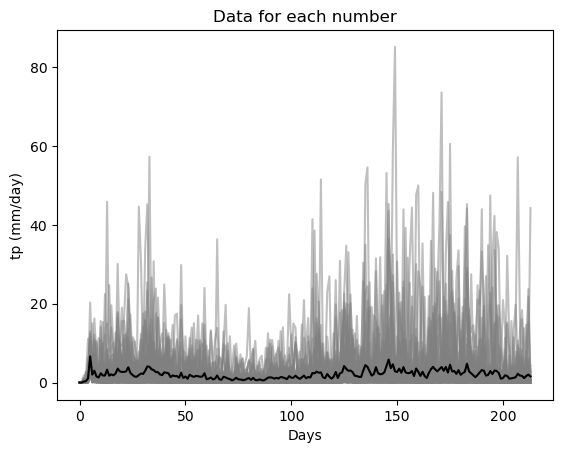

In [18]:
for i in range(num_members):
    # Select the subset of data for the current number
    subset = fore_diff.sel(number=i)*1000
    
    # Plotting
    plt.plot(subset, color='gray', alpha=0.5, label=f'Number {i}')

#plot average in black
plt.plot(fore_diff.mean(dim='number')*1000, color='black')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('tp (mm/day)')
plt.title('Data for each number')
#plt.legend()  # Add legend to differentiate lines
plt.show()
